<a href="https://colab.research.google.com/github/RubenCedillo123/Deep-Learning/blob/main/Copia_de_ClasGalax_TempvsTard_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ***Librerías***

* Estas son todas las líbrerias usadas para este proyecto:

In [ ]:
#básicas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

#tratamiento de datos
import csv
import os
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import preprocess_input as effnet_preprocess

#modelos
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D, Concatenate
from tensorflow.keras.metrics import Precision, Recall, AUC


2025-06-03 01:47:10.429135: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748936830.458871    3280 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748936830.467840    3280 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-06-03 01:47:10.494270: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# ***1. Introducción y Objetivo***


## ***Introducción***

* La clasificación de galaxias en tempranas (Type < 0) y tardías (Type ≥ 0) es un problema fundamental en astronomía, con implicaciones en el entendimiento de la evolución del universo. Tradicionalmente, esta tarea se realiza mediante análisis manual o métodos estadísticos, pero el avance en técnicas de aprendizaje profundo ofrece la oportunidad de automatizar el proceso con mayor precisión y escalabilidad. En este proyecto, se desarrollará una red neuronal capaz de clasificar galaxias utilizando tanto datos estructurados (como índices de color *g-i*, presencia de barras o interacciones tidales) como imágenes asociadas a cada objeto.

* El desafío radica en integrar múltiples fuentes de datos (imágenes y atributos físicos) para mejorar la capacidad predictiva del modelo, mientras se abordan problemas clásicos del machine learning, como el sobreajuste (overfitting), el desbalanceo de clases o la elección óptima de hiperparámetros. Además, se evaluará si técnicas como transfer learning o data augmentation son necesarias para garantizar un modelo robusto y generalizable.

## ***Objetivo***

* El objetivo principal es diseñar, entrenar y validar una red neuronal que clasifique galaxias en tempranas o tardías con alta precisión, utilizando tanto imágenes como datos tabulares (Bars, Tidal, *g-i*). Para ello, se seguirá una metodología estructurada que cubra:

1. Muestreo de datos:

  + Análisis exploratorio (distribución de clases, normalización de características).

  + División equilibrada en conjuntos de entrenamiento, validación y prueba.

2. Arquitectura de la red:

   + Pruebas de topologías (CNN para imágenes, MLP para datos tabulares, o modelos híbridos).

  + Evaluación de capas convolucionales, densas y de concatenación.

3. Pérdidas y métricas:

* Función de pérdida: Binary Cross-Entropy (clasificación binaria).

* Métricas: Precisión, recall, F1-score (importante si hay desbalanceo).

4. Optimización y regularización:

* Optimizadores: Comparación entre Adam, SGD con momentum.

* Técnicas contra overfitting: Dropout, L2/L1 regularization, early stopping.

* Ajuste de learning rate (scheduler o callbacks como ReduceLROnPlateau).

5. Transfer Learning y Data Augmentation:

  * Justificación de usar (o no) modelos preentrenados (ej. ResNet) para extracción de características.

  * Evaluación de aumentos de datos (rotaciones, flips) para imágenes, en caso de datos limitados.

6. Presentación de resultados:

   * Gráficos de evolución de pérdida/accuracy.

   * Matriz de confusión y métricas finales en el conjunto de prueba.

+ El proyecto no solo buscará alcanzar un modelo funcional, sino también documentar el proceso de toma de decisiones para cada componente, destacando cómo se abordaron los desafíos específicos del dataset.

# ***2. Muestreo de Datos***

* Accedemos a nuestra base de datos desde Google Drive y miramos las caracteristicas de la misma:

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')
df_d = pd.read_csv('/home/mauricio/proyectoDL/galaxias.csv')
print(df_d)

                  name  Type  Bars  Tidal     g-i
0      manga-8947-1902  -5.0   0.0    0.0  1.1157
1      manga-8481-1901  -5.0   0.0    0.0 -0.1324
2      manga-9196-6102  -5.0   0.0    0.0  1.1801
3      manga-9512-3703  -5.0   0.0    0.0  1.0456
4      manga-7964-1901  -5.0   0.0    1.0  0.9352
...                ...   ...   ...    ...     ...
5604   manga-8618-6101   NaN   NaN    NaN     NaN
5605   manga-8618-6103   NaN   NaN    NaN     NaN
5606  manga-8651-12703   NaN   NaN    NaN     NaN
5607   manga-8651-3703   NaN   NaN    NaN     NaN
5608   manga-8953-3702   NaN   NaN    NaN     NaN

[5609 rows x 5 columns]


* Tenemos 5609 registros, cada uno con 4 caracteristicas.
* Vemos que tenemos datos sin ningun valor asignado, veamos cuantos son y corrijamoslo:

In [ ]:
num_faltantes = df_d['Type'].isnull().sum()
print(f"- Número de datos faltantes en 'Type': {num_faltantes}", "\n")
df = df_d.dropna(subset=['Type'])

print(df, "\n")

print(f"- Cantidad de NaN: {df['Type'].isnull().sum()}")

- Número de datos faltantes en 'Type': 111 

                  name  Type  Bars  Tidal     g-i
0      manga-8947-1902  -5.0   0.0    0.0  1.1157
1      manga-8481-1901  -5.0   0.0    0.0 -0.1324
2      manga-9196-6102  -5.0   0.0    0.0  1.1801
3      manga-9512-3703  -5.0   0.0    0.0  1.0456
4      manga-7964-1901  -5.0   0.0    1.0  0.9352
...                ...   ...   ...    ...     ...
5493   manga-8148-3704  11.0   0.0    1.0  1.1046
5494  manga-8443-12701  11.0  -0.5    1.0  0.1162
5495  manga-10215-6102  11.0   0.0    1.0  0.3130
5496   manga-8085-6104  11.0   0.5    1.0  0.8186
5497  manga-10510-6103  11.0   0.0    1.0  1.0432

[5498 rows x 5 columns] 

- Cantidad de NaN: 0


* Ahora agregaremos una columna "target", que clasifique según la condición:

`(Type < 0, Type >=0 )`

* Con
  
  * Target == 0: Temprana
  * Target == 1:  Tardía

* Además incluiremos la ruta a su respectiva imagen

In [ ]:
df['Target'] = df['Type'].apply(lambda x: 0 if x < 0 else 1).astype(int)

rc = '/home/mauricio/proyectoDL/galaxiesSample'
df['filename'] = df['name'].astype(str) + '.jpg'
df['filepath'] = df['filename'].apply(lambda x: os.path.join(rc, x))
# Filtramos solo imágenes existentes
df['file_exists'] = df['filepath'].apply(os.path.exists)
df = df[df['file_exists']].copy()
# Convertimos Target a strings (requerido por flow_from_dataframe)
df['Target_str'] = df['Target'].astype(str)

print(df)

                  name  Type  Bars  Tidal     g-i  Target  \
0      manga-8947-1902  -5.0   0.0    0.0  1.1157       0   
1      manga-8481-1901  -5.0   0.0    0.0 -0.1324       0   
2      manga-9196-6102  -5.0   0.0    0.0  1.1801       0   
3      manga-9512-3703  -5.0   0.0    0.0  1.0456       0   
4      manga-7964-1901  -5.0   0.0    1.0  0.9352       0   
...                ...   ...   ...    ...     ...     ...   
5493   manga-8148-3704  11.0   0.0    1.0  1.1046       1   
5494  manga-8443-12701  11.0  -0.5    1.0  0.1162       1   
5495  manga-10215-6102  11.0   0.0    1.0  0.3130       1   
5496   manga-8085-6104  11.0   0.5    1.0  0.8186       1   
5497  manga-10510-6103  11.0   0.0    1.0  1.0432       1   

                  filename                                           filepath  
0      manga-8947-1902.jpg  /home/mauricio/proyectoDL/galaxiesSample/manga...  
1      manga-8481-1901.jpg  /home/mauricio/proyectoDL/galaxiesSample/manga...  
2      manga-9196-6102.jpg 

/tmp/ipykernel_3280/2522810526.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Target'] = df['Type'].apply(lambda x: 0 if x < 0 else 1).astype(int)
/tmp/ipykernel_3280/2522810526.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['filename'] = df['name'].astype(str) + '.jpg'
/tmp/ipykernel_3280/2522810526.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: 

* Ahora visualizemos algunas de las galaxias con las que vamos a trabajar:

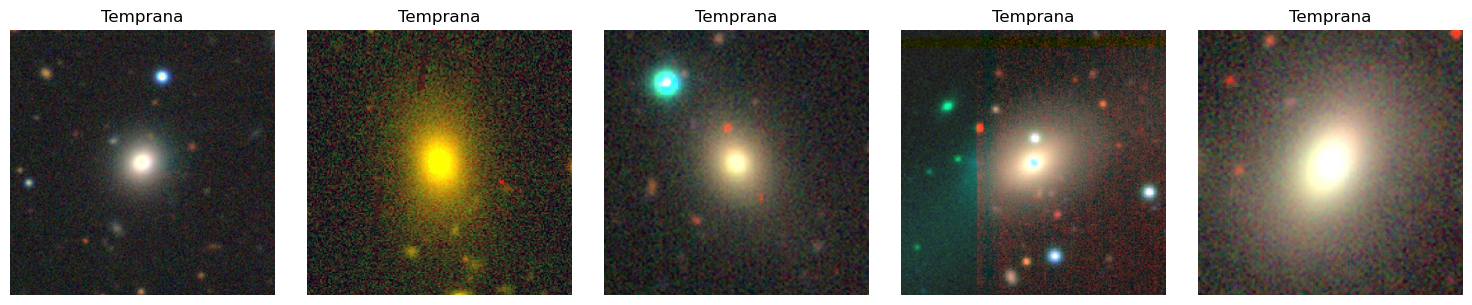

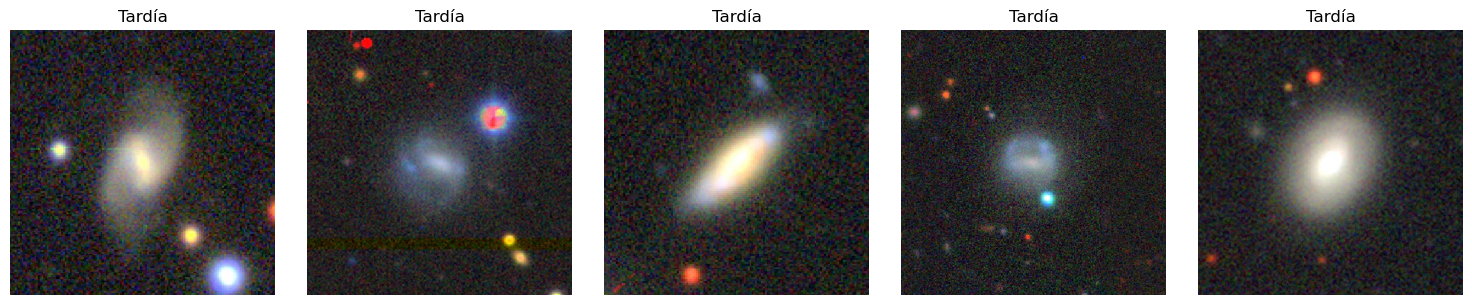

In [ ]:
def mostrar_galaxias(df, clase, n=5):
    subset = df[df['Target'] == clase].sample(n, random_state=42)
    fig, axs = plt.subplots(1, n, figsize=(15, 3))
    for i, (_, row) in enumerate(subset.iterrows()):
        img = Image.open(row['filepath'])
        axs[i].imshow(img)
        axs[i].axis('off')
        axs[i].set_title(f"{'Temprana' if clase == 0 else 'Tardía'}")
    plt.tight_layout()
    plt.show()

mostrar_galaxias(df, clase=0, n=5)
mostrar_galaxias(df, clase=1, n=5)

* Ahora como paso final en el muestreo de datos análizemos el balance del conjunto

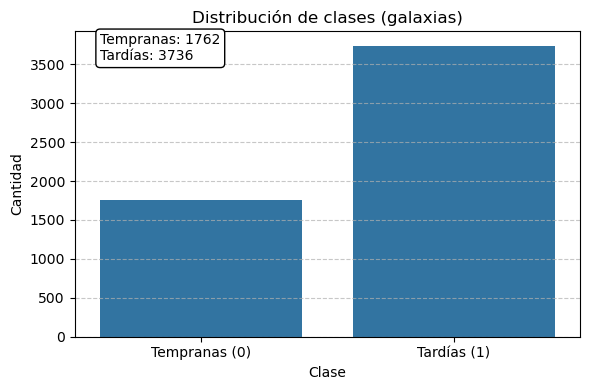



Distribución porcentual:
Target
0    32.05
1    67.95
Name: count, dtype: float64


In [ ]:
conteo = df['Target'].value_counts().sort_index()
labels = ['Tempranas (0)', 'Tardías (1)']

plt.figure(figsize=(6,4))
sns.barplot(x=labels, y=conteo.values)
plt.title("Distribución de clases (galaxias)")
plt.ylabel("Cantidad")
plt.xlabel("Clase")
plt.grid(axis='y', linestyle='--', alpha=0.7)

text = f"Tempranas: {conteo[0]}\nTardías: {conteo[1]}"
plt.text(-0.4, max(conteo.values)*0.95, text, fontsize=10,
         bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.3'))

plt.tight_layout()
plt.show()


total = len(df)
porcentajes = (conteo / total * 100).round(2)
print("\n")
print(f"Distribución porcentual:\n{porcentajes}")

* Esto en automático condiciona la estrucutra de nuestro modelo

# ***3. Preprocesamiento de Datos***

* Iniciamos definiendo algunas variables que usaremos más adelante, es la configuración inicial

In [ ]:
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.15
IMG_SIZE_VGG = (224, 224)
IMG_SIZE_EFFNET = (128, 128)
BATCH_SIZE = 32

* Para la selección de datos entrenamiento/prueba/validación usaremos una divisón estratificada para mantern la proporción de los datos en cada nuevo conjunto

In [ ]:
train_df, test_df = train_test_split(
    df,
    test_size=TEST_SIZE,
    stratify=df['Target'],
    random_state=RANDOM_STATE
)

#conjunto de validación
train_df, val_df = train_test_split(
    train_df,
    test_size=VAL_SIZE/(1-TEST_SIZE),  # Ajuste para porcentaje correcto
    stratify=train_df['Target'],
    random_state=RANDOM_STATE
)


* Ahora incluimos un class weight para manejar el desbalanceo, haciendo que el modelo le de más peso/prioridad a los resultados de la clase minoritaria para evitar que la ignore o se pierda inforamción en los procesos de entrenamiento

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_df['Target']),
    y=train_df['Target']
)
class_weights = {0: class_weights[0], 1: class_weights[1]}

* Para cargar las imágenes decidimos usar un ImageDataGenerator especifico por modelo para evitar que nuestros recursos (RAM) se saturen y el costo en tiempo sea excesivo

In [ ]:
#GENERADORES PARA VGG16

train_datagen_vgg = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_datagen_vgg = ImageDataGenerator(rescale=1./255)

train_generator_vgg = train_datagen_vgg.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='Target_str',  # Usamos la versión string
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator_vgg = val_datagen_vgg.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='Target_str',
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_datagen_vgg = ImageDataGenerator(rescale=1./255)

test_generator_vgg = test_datagen_vgg.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='Target_str',
    target_size=IMG_SIZE_VGG,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)




Found 3573 validated image filenames belonging to 2 classes.


Found 825 validated image filenames belonging to 2 classes.
Found 1100 validated image filenames belonging to 2 classes.


In [ ]:
#GENERADORES PARA EFFICIENTNET

train_datagen_effnet = ImageDataGenerator(
    preprocessing_function=effnet_preprocess,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.1,
    horizontal_flip=True
)

val_datagen_effnet = ImageDataGenerator(
    preprocessing_function=effnet_preprocess
)

train_generator_effnet = train_datagen_effnet.flow_from_dataframe(
    dataframe=train_df,
    x_col='filepath',
    y_col='Target_str',  # Usamos la versión string
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=True
)

val_generator_effnet = val_datagen_effnet.flow_from_dataframe(
    dataframe=val_df,
    x_col='filepath',
    y_col='Target_str',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False
)

test_datagen_effnet = ImageDataGenerator(
    preprocessing_function=effnet_preprocess
)

test_generator_effnet = test_datagen_effnet.flow_from_dataframe(
    dataframe=test_df,
    x_col='filepath',
    y_col='Target_str',
    target_size=IMG_SIZE_EFFNET,
    batch_size=BATCH_SIZE,
    class_mode='binary',
    shuffle=False  # Muy importante para evaluación correcta
)


Found 3573 validated image filenames belonging to 2 classes.
Found 825 validated image filenames belonging to 2 classes.


Found 1100 validated image filenames belonging to 2 classes.


* Finalemente estandarizamos los datos tabulares para poder usarlos libremente en los modelos

In [ ]:
scaler = StandardScaler()
train_tabular = scaler.fit_transform(train_df[['Bars', 'Tidal', 'g-i']])
val_tabular = scaler.transform(val_df[['Bars', 'Tidal', 'g-i']])
test_tabular = scaler.transform(test_df[['Bars', 'Tidal', 'g-i']])


# ***4. Definición de la Arquitectura del Modelo***

* Primer Modelo: VGG16
  + Modelo profundo preentrenado con 16 capas personalizables


In [ ]:
from tensorflow.keras.applications import VGG16

# Configuración mejorada
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Congelar modelo base
for layer in base_model.layers:
    layer.trainable = False

# Arquitectura
x = Flatten()(base_model.output)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model_vgg = Model(inputs=base_model.input, outputs=output)

# Compilación con más métricas

model_vgg.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall'),
             AUC(name='auc')]
)



# Callbacks mejorados
callbacks_vgg = [
    EarlyStopping(patience=7, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_vgg_model.h5', monitor='val_accuracy', save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6)
]

I0000 00:00:1748936877.602314    3280 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1767 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2050, pci bus id: 0000:01:00.0, compute capability: 8.6


* Segundo Modelo: EfficientNetB0
  + Especializada en clasificación binaria

In [ ]:
from tensorflow.keras.applications import EfficientNetB0

# Configuración
base_model = EfficientNetB0(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet',
    pooling='avg'
)

# Congelar modelo base
base_model.trainable = False

# Arquitectura mejorada
inputs = tf.keras.Input(shape=(128, 128, 3))
x = base_model(inputs, training=False)
x = Dropout(0.5)(x)
outputs = Dense(1, activation='sigmoid')(x)

model_effnet = Model(inputs, outputs)

# Compilación
model_effnet.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             tf.keras.metrics.AUC(name='auc'),
             tf.keras.metrics.Precision(name='precision'),
             tf.keras.metrics.Recall(name='recall')]
)

# Callbacks
callbacks_effnet = [
    EarlyStopping(patience=5, monitor='val_auc', mode='max', restore_best_weights=True),
    ModelCheckpoint('best_effnet_model.h5', monitor='val_auc', save_best_only=True, mode='max'),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2)
]

* Tercer Modelo

In [ ]:
# Rama de imágenes (EfficientNet)
img_input = Input(shape=(128, 128, 3), name='image_input')
base_model = EfficientNetB0(include_top=False, weights='imagenet', input_tensor=img_input)

# Congelar las capas del modelo base
for layer in base_model.layers:
    layer.trainable = False

x_img = GlobalAveragePooling2D()(base_model.output)
x_img = Dropout(0.5)(x_img)

# Rama de datos tabulares
tabular_input = Input(shape=(3,), name='tabular_input')  # Bars, Tidal, g-i
x_tab = Dense(64, activation='relu')(tabular_input)
x_tab = BatchNormalization()(x_tab)
x_tab = Dropout(0.3)(x_tab)

#Fusión de las Ramas
combined = Concatenate()([x_img, x_tab])

# Capas fully connected después de la fusión
x = Dense(128, activation='relu')(combined)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
output = Dense(1, activation='sigmoid')(x)


#modelo Híbrido
model_hybrid = Model(inputs=[img_input, tabular_input], outputs=output)

#compilación
model_hybrid.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy',
             Precision(name='precision'),
             Recall(name='recall'),
             AUC(name='auc')]
)

#Generador de Datos Híbrido (Versión definitiva)

def hybrid_generator(image_generator, tabular_data, class_weights):
    while True:
        # Obtener batch de imágenes
        batch_images, batch_labels = next(image_generator)

        # Obtener los índices reales usados por el generador de imágenes
        batch_indices = image_generator.index_array

        # Verificar que los índices estén dentro del rango de datos tabulares
        batch_indices = batch_indices[batch_indices < len(tabular_data)]

        # Obtener datos tabulares correspondientes
        batch_tabular = tabular_data[batch_indices]

        # Verificar que tengamos el mismo número de muestras
        if len(batch_images) != len(batch_tabular):
            # Si no coinciden, tomar solo las primeras n muestras que coincidan
            min_length = min(len(batch_images), len(batch_tabular))
            batch_images = batch_images[:min_length]
            batch_tabular = batch_tabular[:min_length]
            batch_labels = batch_labels[:min_length]

        # Calcular sample weights
        sample_weights = np.array([class_weights[int(label)] for label in batch_labels])

        yield {'image_input': batch_images, 'tabular_input': batch_tabular}, batch_labels, sample_weights

# Crear datasets robustos
def create_dataset(generator, tabular_data, class_weights):
    output_signature = (
        {
            'image_input': tf.TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32),
            'tabular_input': tf.TensorSpec(shape=(None, 3), dtype=tf.float32)
        },
        tf.TensorSpec(shape=(None,), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )

    return tf.data.Dataset.from_generator(
        lambda: hybrid_generator(generator, tabular_data, class_weights),
        output_signature=output_signature
    ).prefetch(tf.data.AUTOTUNE)

# Asegurar que los datos tabulares sean numpy arrays
train_tabular = np.array(train_tabular, dtype=np.float32)
val_tabular = np.array(val_tabular, dtype=np.float32)

# Verificar dimensiones
print(f"Train images: {len(train_generator_effnet)} samples")
print(f"Train tabular: {len(train_tabular)} samples")
print(f"Val images: {len(val_generator_effnet)} samples")
print(f"Val tabular: {len(val_tabular)} samples")

# Crear datasets
train_dataset = create_dataset(train_generator_effnet, train_tabular, class_weights)
val_dataset = create_dataset(val_generator_effnet, val_tabular, class_weights)


Train images: 112 samples
Train tabular: 3573 samples
Val images: 26 samples
Val tabular: 825 samples


# ***5. Entrenamientos***

* Primer Modelo


In [ ]:
# Entrenamiento
history_vgg = model_vgg.fit(
    train_generator_vgg,
    steps_per_epoch=len(train_generator_vgg),
    validation_data=val_generator_vgg,
    validation_steps=len(val_generator_vgg),
    epochs=20,
    callbacks=callbacks_vgg,
    class_weight=class_weights
)

/home/mauricio/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step - accuracy: 0.6130 - auc: 0.6844 - loss: 0.7754 - precision: 0.7854 - recall: 0.5805

112/112 ━━━━━━━━━━━━━━━━━━━━ 68s 560ms/step - accuracy: 0.6133 - auc: 0.6849 - loss: 0.7747 - precision: 0.7857 - recall: 0.5809 - val_accuracy: 0.7600 - val_auc: 0.8914 - val_loss: 0.4523 - val_precision: 0.7463 - val_recall: 0.9804 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 288ms/step - accuracy: 0.7262 - auc: 0.8138 - loss: 0.5645 - precision: 0.8683 - recall: 0.7007

112/112 ━━━━━━━━━━━━━━━━━━━━ 42s 362ms/step - accuracy: 0.7263 - auc: 0.8139 - loss: 0.5644 - precision: 0.8684 - recall: 0.7008 - val_accuracy: 0.8497 - val_auc: 0.9304 - val_loss: 0.3618 - val_precision: 0.9450 - val_recall: 0.8271 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 324ms/step - accuracy: 0.7561 - auc: 0.8480 - loss: 0.5157 - precision: 0.8936 - recall: 0.7305 - val_accuracy: 0.8230 - val_auc: 0.9325 - val_loss: 0.3887 - val_precision: 0.9621 - val_recall: 0.7701 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step - accuracy: 0.7813 - auc: 0.8655 - loss: 0.4841 - precision: 0.9011 - recall: 0.7586

112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 354ms/step - accuracy: 0.7812 - auc: 0.8655 - loss: 0.4842 - precision: 0.9011 - recall: 0.7586 - val_accuracy: 0.8703 - val_auc: 0.9346 - val_loss: 0.3148 - val_precision: 0.9316 - val_recall: 0.8734 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 342ms/step - accuracy: 0.7817 - auc: 0.8787 - loss: 0.4636 - precision: 0.9041 - recall: 0.7540 - val_accuracy: 0.8655 - val_auc: 0.9288 - val_loss: 0.3280 - val_precision: 0.8827 - val_recall: 0.9251 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 40s 353ms/step - accuracy: 0.7977 - auc: 0.8856 - loss: 0.4459 - precision: 0.8993 - recall: 0.7871 - val_accuracy: 0.8570 - val_auc: 0.9352 - val_loss: 0.3172 - val_precision: 0.9284 - val_recall: 0.8556 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.7844 - auc: 0.8692 - loss: 0.5042 - precision: 0.8873 - recall: 0.7811

112/112 ━━━━━━━━━━━━━━━━━━━━ 39s 346ms/step - accuracy: 0.7844 - auc: 0.8692 - loss: 0.5039 - precision: 0.8873 - recall: 0.7811 - val_accuracy: 0.8776 - val_auc: 0.9408 - val_loss: 0.3092 - val_precision: 0.9510 - val_recall: 0.8645 - learning_rate: 1.0000e-04
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 41s 361ms/step - accuracy: 0.7890 - auc: 0.8884 - loss: 0.4327 - precision: 0.9207 - recall: 0.7604 - val_accuracy: 0.8521 - val_auc: 0.9374 - val_loss: 0.3447 - val_precision: 0.9563 - val_recall: 0.8200 - learning_rate: 1.0000e-04
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 327ms/step - accuracy: 0.8027 - auc: 0.8909 - loss: 0.4427 - precision: 0.9067 - recall: 0.7889 - val_accuracy: 0.8679 - val_auc: 0.9394 - val_loss: 0.3067 - val_precision: 0.9330 - val_recall: 0.8681 - learning_rate: 1.0000e-04
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 37s 332ms/step - accuracy: 0.8231 - auc: 0.9143 - loss: 0.3704 - precision: 0.9326 - recall: 0.8007 - val_accuracy: 0.8533 - val_auc: 0.9409 - val_loss

* Segundo Modelo

In [ ]:
history_effnet = model_effnet.fit(
    train_generator_effnet,
    steps_per_epoch=len(train_generator_effnet),
    validation_data=val_generator_effnet,
    validation_steps=len(val_generator_effnet),
    epochs=20,
    callbacks=callbacks_effnet,
    verbose=1
)

# 7. Fine-Tuning
def unfreeze_model(model_effnet):
    # Descongelar las últimas capas para fine-tuning
    for layer in model_effnet.layers[-20:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True

    model_effnet.compile(
        optimizer=Adam(learning_rate=1e-5),  # LR más bajo para fine-tuning
        loss='binary_crossentropy',
        metrics=['accuracy',
                 tf.keras.metrics.Precision(name='precision'),
                 tf.keras.metrics.Recall(name='recall'),
                 tf.keras.metrics.AUC(name='auc')]
    )

unfreeze_model(model_effnet)

# Continuar entrenamiento para fine-tuning
initial_epoch = history_effnet.epoch[-1] + 1
history_fine = model_effnet.fit(
    train_generator_effnet,
    steps_per_epoch=len(train_generator_effnet),
    validation_data=val_generator_effnet,
    validation_steps=len(val_generator_effnet),
    epochs=initial_epoch + 15,  # 15 más
    initial_epoch=initial_epoch,
    callbacks=callbacks_effnet,
    verbose=1
)


/home/mauricio/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20


I0000 00:00:1748936904.587397    3537 service.cc:148] XLA service 0x7e3e3804de90 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748936904.587464    3537 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 2050, Compute Capability 8.6
2025-06-03 01:48:24.926604: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1748936906.308716    3537 cuda_dnn.cc:529] Loaded cuDNN version 91001
E0000 00:00:1748936912.799290    3537 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748936913.006589    3537 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-03 01:48:33.351585: E externa

 78/112 ━━━━━━━━━━━━━━━━━━━━ 4s 139ms/step - accuracy: 0.5434 - auc: 0.5190 - loss: 0.7027 - precision: 0.6841 - recall: 0.6167

2025-06-03 01:49:08.787532: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[21,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,480,8,8]{3,2,1,0}, f32[480,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-03 01:49:09.132605: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.345212053s
Trying algorithm eng3{k11=2} for conv (f32[21,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,480,8,8]{3,2,1,0}, f32[480,1,3,3]{3,2,1,0}), window={size=3x3 pad=1_1x1_1}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config=

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.5601 - auc: 0.5235 - loss: 0.6932 - precision: 0.6850 - recall: 0.6584

2025-06-03 01:49:45.603675: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[25,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,480,8,8]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-03 01:49:46.483544: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.882755078s
Trying algorithm eng3{k11=2} for conv (f32[25,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[25,480,8,8]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config=

112/112 ━━━━━━━━━━━━━━━━━━━━ 103s 611ms/step - accuracy: 0.5605 - auc: 0.5236 - loss: 0.6930 - precision: 0.6850 - recall: 0.6594 - val_accuracy: 0.6800 - val_auc: 0.7021 - val_loss: 0.6045 - val_precision: 0.6804 - val_recall: 0.9982 - learning_rate: 1.0000e-04
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.6703 - auc: 0.6259 - loss: 0.6106 - precision: 0.7015 - recall: 0.8935

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.6703 - auc: 0.6260 - loss: 0.6105 - precision: 0.7015 - recall: 0.8934 - val_accuracy: 0.6800 - val_auc: 0.8316 - val_loss: 0.5638 - val_precision: 0.6804 - val_recall: 0.9982 - learning_rate: 1.0000e-04
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7043 - auc: 0.6938 - loss: 0.5691 - precision: 0.7227 - recall: 0.9236

112/112 ━━━━━━━━━━━━━━━━━━━━ 22s 148ms/step - accuracy: 0.7043 - auc: 0.6938 - loss: 0.5692 - precision: 0.7226 - recall: 0.9235 - val_accuracy: 0.6848 - val_auc: 0.8723 - val_loss: 0.5296 - val_precision: 0.6847 - val_recall: 0.9947 - learning_rate: 1.0000e-04
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - accuracy: 0.6999 - auc: 0.7049 - loss: 0.5681 - precision: 0.7235 - recall: 0.9050

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.6999 - auc: 0.7050 - loss: 0.5680 - precision: 0.7235 - recall: 0.9050 - val_accuracy: 0.6945 - val_auc: 0.8873 - val_loss: 0.5049 - val_precision: 0.6919 - val_recall: 0.9929 - learning_rate: 1.0000e-04
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7171 - auc: 0.7493 - loss: 0.5406 - precision: 0.7373 - recall: 0.9051

112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 142ms/step - accuracy: 0.7171 - auc: 0.7493 - loss: 0.5405 - precision: 0.7373 - recall: 0.9051 - val_accuracy: 0.7127 - val_auc: 0.8937 - val_loss: 0.4842 - val_precision: 0.7072 - val_recall: 0.9857 - learning_rate: 1.0000e-04
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step - accuracy: 0.7189 - auc: 0.7535 - loss: 0.5344 - precision: 0.7451 - recall: 0.8925

112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 161ms/step - accuracy: 0.7190 - auc: 0.7537 - loss: 0.5343 - precision: 0.7451 - recall: 0.8925 - val_accuracy: 0.7273 - val_auc: 0.8974 - val_loss: 0.4684 - val_precision: 0.7188 - val_recall: 0.9840 - learning_rate: 1.0000e-04
Epoch 7/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.7275 - auc: 0.7821 - loss: 0.5206 - precision: 0.7480 - recall: 0.8910

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 142ms/step - accuracy: 0.7275 - auc: 0.7821 - loss: 0.5206 - precision: 0.7481 - recall: 0.8910 - val_accuracy: 0.7345 - val_auc: 0.9005 - val_loss: 0.4615 - val_precision: 0.7221 - val_recall: 0.9911 - learning_rate: 1.0000e-04
Epoch 8/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7418 - auc: 0.8084 - loss: 0.4952 - precision: 0.7586 - recall: 0.9058

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.7418 - auc: 0.8083 - loss: 0.4952 - precision: 0.7587 - recall: 0.9057 - val_accuracy: 0.7430 - val_auc: 0.9036 - val_loss: 0.4453 - val_precision: 0.7299 - val_recall: 0.9875 - learning_rate: 1.0000e-04
Epoch 9/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step - accuracy: 0.7231 - auc: 0.7809 - loss: 0.5131 - precision: 0.7530 - recall: 0.8850

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7232 - auc: 0.7810 - loss: 0.5130 - precision: 0.7530 - recall: 0.8850 - val_accuracy: 0.7600 - val_auc: 0.9058 - val_loss: 0.4320 - val_precision: 0.7483 - val_recall: 0.9750 - learning_rate: 1.0000e-04
Epoch 10/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 140ms/step - accuracy: 0.7570 - auc: 0.8100 - loss: 0.4849 - precision: 0.7829 - recall: 0.8975

112/112 ━━━━━━━━━━━━━━━━━━━━ 18s 159ms/step - accuracy: 0.7570 - auc: 0.8100 - loss: 0.4849 - precision: 0.7828 - recall: 0.8975 - val_accuracy: 0.7745 - val_auc: 0.9071 - val_loss: 0.4250 - val_precision: 0.7637 - val_recall: 0.9679 - learning_rate: 1.0000e-04
Epoch 11/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step - accuracy: 0.7406 - auc: 0.7944 - loss: 0.4952 - precision: 0.7782 - recall: 0.8764

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.7407 - auc: 0.7946 - loss: 0.4951 - precision: 0.7782 - recall: 0.8765 - val_accuracy: 0.7794 - val_auc: 0.9084 - val_loss: 0.4206 - val_precision: 0.7643 - val_recall: 0.9768 - learning_rate: 1.0000e-04
Epoch 12/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 126ms/step - accuracy: 0.7657 - auc: 0.8275 - loss: 0.4686 - precision: 0.7920 - recall: 0.8939

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.7657 - auc: 0.8275 - loss: 0.4686 - precision: 0.7919 - recall: 0.8938 - val_accuracy: 0.7879 - val_auc: 0.9094 - val_loss: 0.4158 - val_precision: 0.7718 - val_recall: 0.9768 - learning_rate: 1.0000e-04
Epoch 13/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.7500 - auc: 0.8239 - loss: 0.4772 - precision: 0.7787 - recall: 0.8840

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 146ms/step - accuracy: 0.7500 - auc: 0.8239 - loss: 0.4772 - precision: 0.7787 - recall: 0.8841 - val_accuracy: 0.7903 - val_auc: 0.9107 - val_loss: 0.4113 - val_precision: 0.7748 - val_recall: 0.9750 - learning_rate: 1.0000e-04
Epoch 14/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 135ms/step - accuracy: 0.7653 - auc: 0.8343 - loss: 0.4658 - precision: 0.7952 - recall: 0.8807

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 153ms/step - accuracy: 0.7653 - auc: 0.8342 - loss: 0.4658 - precision: 0.7952 - recall: 0.8806 - val_accuracy: 0.7842 - val_auc: 0.9114 - val_loss: 0.4139 - val_precision: 0.7686 - val_recall: 0.9768 - learning_rate: 1.0000e-04
Epoch 15/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.7533 - auc: 0.8296 - loss: 0.4602 - precision: 0.7871 - recall: 0.8821

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7533 - auc: 0.8296 - loss: 0.4603 - precision: 0.7871 - recall: 0.8821 - val_accuracy: 0.7927 - val_auc: 0.9123 - val_loss: 0.4074 - val_precision: 0.7770 - val_recall: 0.9750 - learning_rate: 1.0000e-04
Epoch 16/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.7575 - auc: 0.8348 - loss: 0.4648 - precision: 0.7869 - recall: 0.8790

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.7576 - auc: 0.8349 - loss: 0.4647 - precision: 0.7870 - recall: 0.8790 - val_accuracy: 0.7976 - val_auc: 0.9132 - val_loss: 0.4039 - val_precision: 0.7814 - val_recall: 0.9750 - learning_rate: 1.0000e-04
Epoch 17/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 137ms/step - accuracy: 0.7743 - auc: 0.8402 - loss: 0.4567 - precision: 0.7983 - recall: 0.8941

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 154ms/step - accuracy: 0.7744 - auc: 0.8402 - loss: 0.4567 - precision: 0.7983 - recall: 0.8941 - val_accuracy: 0.8024 - val_auc: 0.9136 - val_loss: 0.4015 - val_precision: 0.7859 - val_recall: 0.9750 - learning_rate: 1.0000e-04
Epoch 18/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7849 - auc: 0.8418 - loss: 0.4519 - precision: 0.8141 - recall: 0.8920

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.7848 - auc: 0.8418 - loss: 0.4519 - precision: 0.8140 - recall: 0.8921 - val_accuracy: 0.8133 - val_auc: 0.9150 - val_loss: 0.3899 - val_precision: 0.8006 - val_recall: 0.9661 - learning_rate: 1.0000e-04
Epoch 19/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.7737 - auc: 0.8503 - loss: 0.4491 - precision: 0.8047 - recall: 0.8762

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 151ms/step - accuracy: 0.7738 - auc: 0.8502 - loss: 0.4491 - precision: 0.8047 - recall: 0.8762 - val_accuracy: 0.8048 - val_auc: 0.9153 - val_loss: 0.3957 - val_precision: 0.7890 - val_recall: 0.9733 - learning_rate: 1.0000e-04
Epoch 20/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 132ms/step - accuracy: 0.7645 - auc: 0.8292 - loss: 0.4628 - precision: 0.7955 - recall: 0.8845

112/112 ━━━━━━━━━━━━━━━━━━━━ 17s 150ms/step - accuracy: 0.7646 - auc: 0.8292 - loss: 0.4627 - precision: 0.7955 - recall: 0.8845 - val_accuracy: 0.8024 - val_auc: 0.9157 - val_loss: 0.3953 - val_precision: 0.7876 - val_recall: 0.9715 - learning_rate: 1.0000e-04
Epoch 21/35


E0000 00:00:1748937372.188854    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748937372.424334    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748937372.739748    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-03 01:56:12.827353: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[32,672,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[32,672,15,15]{3,2,1,0}, f32[672,1,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mod

  8/112 ━━━━━━━━━━━━━━━━━━━━ 12s 122ms/step - accuracy: 0.5374 - auc: 0.5612 - loss: 0.7176 - precision: 0.6746 - recall: 0.5889

E0000 00:00:1748937424.518866    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748937424.838288    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1748937425.155800    3539 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
2025-06-03 01:57:05.211714: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[21,672,11,11]{3,2,1,0}, u8[0]{0}) custom-call(f32[21,672,15,15]{3,2,1,0}, f32[672,1,5,5]{3,2,1,0}), window={size=5x5}, dim_labels=bf01_oi01->bf01, feature_group_count=672, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mod

112/112 ━━━━━━━━━━━━━━━━━━━━ 155s 597ms/step - accuracy: 0.5864 - auc: 0.6167 - loss: 0.6872 - precision: 0.7356 - recall: 0.6007 - val_accuracy: 0.7527 - val_auc: 0.8622 - val_loss: 0.4746 - val_precision: 0.7396 - val_recall: 0.9822 - learning_rate: 1.0000e-05
Epoch 22/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 134ms/step - accuracy: 0.6897 - auc: 0.7513 - loss: 0.5762 - precision: 0.8121 - recall: 0.7108 - val_accuracy: 0.8000 - val_auc: 0.8633 - val_loss: 0.4529 - val_precision: 0.8183 - val_recall: 0.9073 - learning_rate: 1.0000e-05
Epoch 23/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 121ms/step - accuracy: 0.7606 - auc: 0.8336 - loss: 0.5021 - precision: 0.8581 - recall: 0.7692 - val_accuracy: 0.8182 - val_auc: 0.8808 - val_loss: 0.4516 - val_precision: 0.8785 - val_recall: 0.8503 - learning_rate: 1.0000e-05
Epoch 24/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.8006 - auc: 0.8791 - loss: 0.4420 - precision: 0.8849 - recall: 0.8066 - val_accuracy: 0.8145 - val_auc: 0.8971 - val_l

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 140ms/step - accuracy: 0.8293 - auc: 0.8990 - loss: 0.3929 - precision: 0.8945 - recall: 0.8469 - val_accuracy: 0.8255 - val_auc: 0.9169 - val_loss: 0.4015 - val_precision: 0.9145 - val_recall: 0.8200 - learning_rate: 1.0000e-05
Epoch 27/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8517 - auc: 0.9182 - loss: 0.3546 - precision: 0.9133 - recall: 0.8673

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 132ms/step - accuracy: 0.8516 - auc: 0.9182 - loss: 0.3547 - precision: 0.9132 - recall: 0.8673 - val_accuracy: 0.8327 - val_auc: 0.9218 - val_loss: 0.3835 - val_precision: 0.9155 - val_recall: 0.8307 - learning_rate: 1.0000e-05
Epoch 28/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - accuracy: 0.8499 - auc: 0.9206 - loss: 0.3507 - precision: 0.9033 - recall: 0.8705

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 138ms/step - accuracy: 0.8499 - auc: 0.9206 - loss: 0.3507 - precision: 0.9033 - recall: 0.8705 - val_accuracy: 0.8461 - val_auc: 0.9270 - val_loss: 0.3695 - val_precision: 0.9272 - val_recall: 0.8396 - learning_rate: 1.0000e-05
Epoch 29/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8552 - auc: 0.9265 - loss: 0.3349 - precision: 0.9081 - recall: 0.8755

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 135ms/step - accuracy: 0.8552 - auc: 0.9265 - loss: 0.3349 - precision: 0.9081 - recall: 0.8755 - val_accuracy: 0.8485 - val_auc: 0.9305 - val_loss: 0.3557 - val_precision: 0.9275 - val_recall: 0.8431 - learning_rate: 1.0000e-05
Epoch 30/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8593 - auc: 0.9273 - loss: 0.3306 - precision: 0.9180 - recall: 0.8734

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 145ms/step - accuracy: 0.8593 - auc: 0.9273 - loss: 0.3305 - precision: 0.9179 - recall: 0.8735 - val_accuracy: 0.8509 - val_auc: 0.9343 - val_loss: 0.3414 - val_precision: 0.9277 - val_recall: 0.8467 - learning_rate: 1.0000e-05
Epoch 31/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step - accuracy: 0.8541 - auc: 0.9225 - loss: 0.3344 - precision: 0.9041 - recall: 0.8809

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 136ms/step - accuracy: 0.8541 - auc: 0.9225 - loss: 0.3344 - precision: 0.9041 - recall: 0.8809 - val_accuracy: 0.8558 - val_auc: 0.9367 - val_loss: 0.3367 - val_precision: 0.9333 - val_recall: 0.8485 - learning_rate: 1.0000e-05
Epoch 32/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 122ms/step - accuracy: 0.8661 - auc: 0.9311 - loss: 0.3159 - precision: 0.9111 - recall: 0.8929

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 143ms/step - accuracy: 0.8661 - auc: 0.9311 - loss: 0.3159 - precision: 0.9110 - recall: 0.8929 - val_accuracy: 0.8594 - val_auc: 0.9394 - val_loss: 0.3235 - val_precision: 0.9320 - val_recall: 0.8556 - learning_rate: 1.0000e-05
Epoch 33/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8660 - auc: 0.9343 - loss: 0.3085 - precision: 0.9059 - recall: 0.8961

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 131ms/step - accuracy: 0.8660 - auc: 0.9343 - loss: 0.3085 - precision: 0.9059 - recall: 0.8961 - val_accuracy: 0.8533 - val_auc: 0.9425 - val_loss: 0.3186 - val_precision: 0.9297 - val_recall: 0.8485 - learning_rate: 1.0000e-05
Epoch 34/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8708 - auc: 0.9377 - loss: 0.2970 - precision: 0.9062 - recall: 0.9044

112/112 ━━━━━━━━━━━━━━━━━━━━ 16s 139ms/step - accuracy: 0.8707 - auc: 0.9377 - loss: 0.2971 - precision: 0.9061 - recall: 0.9044 - val_accuracy: 0.8606 - val_auc: 0.9430 - val_loss: 0.3126 - val_precision: 0.9305 - val_recall: 0.8592 - learning_rate: 1.0000e-05
Epoch 35/35
112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.8661 - auc: 0.9312 - loss: 0.3152 - precision: 0.9025 - recall: 0.9009

112/112 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - accuracy: 0.8660 - auc: 0.9312 - loss: 0.3152 - precision: 0.9024 - recall: 0.9008 - val_accuracy: 0.8630 - val_auc: 0.9457 - val_loss: 0.3044 - val_precision: 0.9308 - val_recall: 0.8627 - learning_rate: 1.0000e-05


* Tercer Modelo

In [ ]:
try:
    history_hybrid = model_hybrid.fit(
        train_dataset,
        steps_per_epoch=len(train_generator_effnet),
        validation_data=val_dataset,
        validation_steps=len(val_generator_effnet),
        epochs=30,
        callbacks=callbacks_effnet
    )
except Exception as e:
    print(f"Error durante el entrenamiento: {e}")

Epoch 1/30


E0000 00:00:1748938228.369048    3536 buffer_comparator.cc:157] Difference at 0: 7.86853, expected 6.94606
E0000 00:00:1748938228.370245    3536 buffer_comparator.cc:157] Difference at 2: 6.77838, expected 5.48021
E0000 00:00:1748938228.370257    3536 buffer_comparator.cc:157] Difference at 3: 7.71764, expected 9.18898
E0000 00:00:1748938228.370263    3536 buffer_comparator.cc:157] Difference at 10: 9.1362, expected 7.97835
E0000 00:00:1748938228.370268    3536 buffer_comparator.cc:157] Difference at 13: 9.56187, expected 7.93424
E0000 00:00:1748938228.370271    3536 buffer_comparator.cc:157] Difference at 16: -0.0896125, expected 6.86238
E0000 00:00:1748938228.370275    3536 buffer_comparator.cc:157] Difference at 17: 0.0335768, expected 7.83918
E0000 00:00:1748938228.370278    3536 buffer_comparator.cc:157] Difference at 18: 0.0929186, expected 8.54509
E0000 00:00:1748938228.370282    3536 buffer_comparator.cc:157] Difference at 19: 0.0698888, expected 7.47085
E0000 00:00:1748938228.

105/112 ━━━━━━━━━━━━━━━━━━━━ 1s 155ms/step - accuracy: 0.5512 - auc: 0.5987 - loss: 0.8885 - precision: 0.7250 - recall: 0.5311

E0000 00:00:1748938253.881421    3535 buffer_comparator.cc:157] Difference at 1: 6.88127, expected 5.84345
E0000 00:00:1748938253.881489    3535 buffer_comparator.cc:157] Difference at 4: 6.43589, expected 4.61851
E0000 00:00:1748938253.881498    3535 buffer_comparator.cc:157] Difference at 5: 5.66354, expected 4.45649
E0000 00:00:1748938253.881501    3535 buffer_comparator.cc:157] Difference at 9: 6.35735, expected 5.27382
E0000 00:00:1748938253.881503    3535 buffer_comparator.cc:157] Difference at 10: 6.43573, expected 5.58014
E0000 00:00:1748938253.881505    3535 buffer_comparator.cc:157] Difference at 12: 6.72564, expected 5.40351
E0000 00:00:1748938253.881508    3535 buffer_comparator.cc:157] Difference at 13: 6.23054, expected 5.46731
E0000 00:00:1748938253.881510    3535 buffer_comparator.cc:157] Difference at 16: 0.0961672, expected 5.85223
E0000 00:00:1748938253.881513    3535 buffer_comparator.cc:157] Difference at 17: 0.0650829, expected 6.05115
E0000 00:00:1748938253.88151

112/112 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step - accuracy: 0.5530 - auc: 0.6015 - loss: 0.8832 - precision: 0.7276 - recall: 0.5323

2025-06-03 02:11:07.702169: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 4 bytes spill stores, 4 bytes spill loads

2025-06-03 02:11:12.896371: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion', 8 bytes spill stores, 8 bytes spill loads



112/112 ━━━━━━━━━━━━━━━━━━━━ 58s 341ms/step - accuracy: 0.5532 - auc: 0.6019 - loss: 0.8825 - precision: 0.7279 - recall: 0.5324 - val_accuracy: 0.8133 - val_auc: 0.8864 - val_loss: 0.4769 - val_precision: 0.8589 - val_recall: 0.8681 - learning_rate: 1.0000e-04
Epoch 2/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 13s 117ms/step - accuracy: 0.6048 - auc: 0.6906 - loss: 0.7511 - precision: 0.8086 - recall: 0.5602 - val_accuracy: 0.8267 - val_auc: 0.9043 - val_loss: 0.4413 - val_precision: 0.8554 - val_recall: 0.8966 - learning_rate: 1.0000e-04
Epoch 3/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 124ms/step - accuracy: 0.6712 - auc: 0.7574 - loss: 0.6462 - precision: 0.8544 - recall: 0.6278 - val_accuracy: 0.8412 - val_auc: 0.9111 - val_loss: 0.4038 - val_precision: 0.8826 - val_recall: 0.8841 - learning_rate: 1.0000e-04
Epoch 4/30
112/112 ━━━━━━━━━━━━━━━━━━━━ 14s 125ms/step - accuracy: 0.6736 - auc: 0.7653 - loss: 0.6351 - precision: 0.8516 - recall: 0.6299 - val_accuracy: 0.8400 - val_auc: 0.9154 - val_loss:

# ***6. Gráficas***

In [ ]:
def plot_hybrid_history(history):
    plt.figure(figsize=(15, 10))

    # Accuracy
    plt.subplot(2, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Val Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss
    plt.subplot(2, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title('Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Precision
    if 'precision' in history.history:
        plt.subplot(2, 2, 3)
        plt.plot(history.history['precision'], label='Train Precision')
        plt.plot(history.history['val_precision'], label='Val Precision')
        plt.title('Precision')
        plt.xlabel('Epoch')
        plt.ylabel('Precision')
        plt.legend()

    # Recall
    if 'recall' in history.history:
        plt.subplot(2, 2, 4)
        plt.plot(history.history['recall'], label='Train Recall')
        plt.plot(history.history['val_recall'], label='Val Recall')
        plt.title('Recall')
        plt.xlabel('Epoch')
        plt.ylabel('Recall')
        plt.legend()

    plt.tight_layout()
    plt.show()


* Primer Modelo

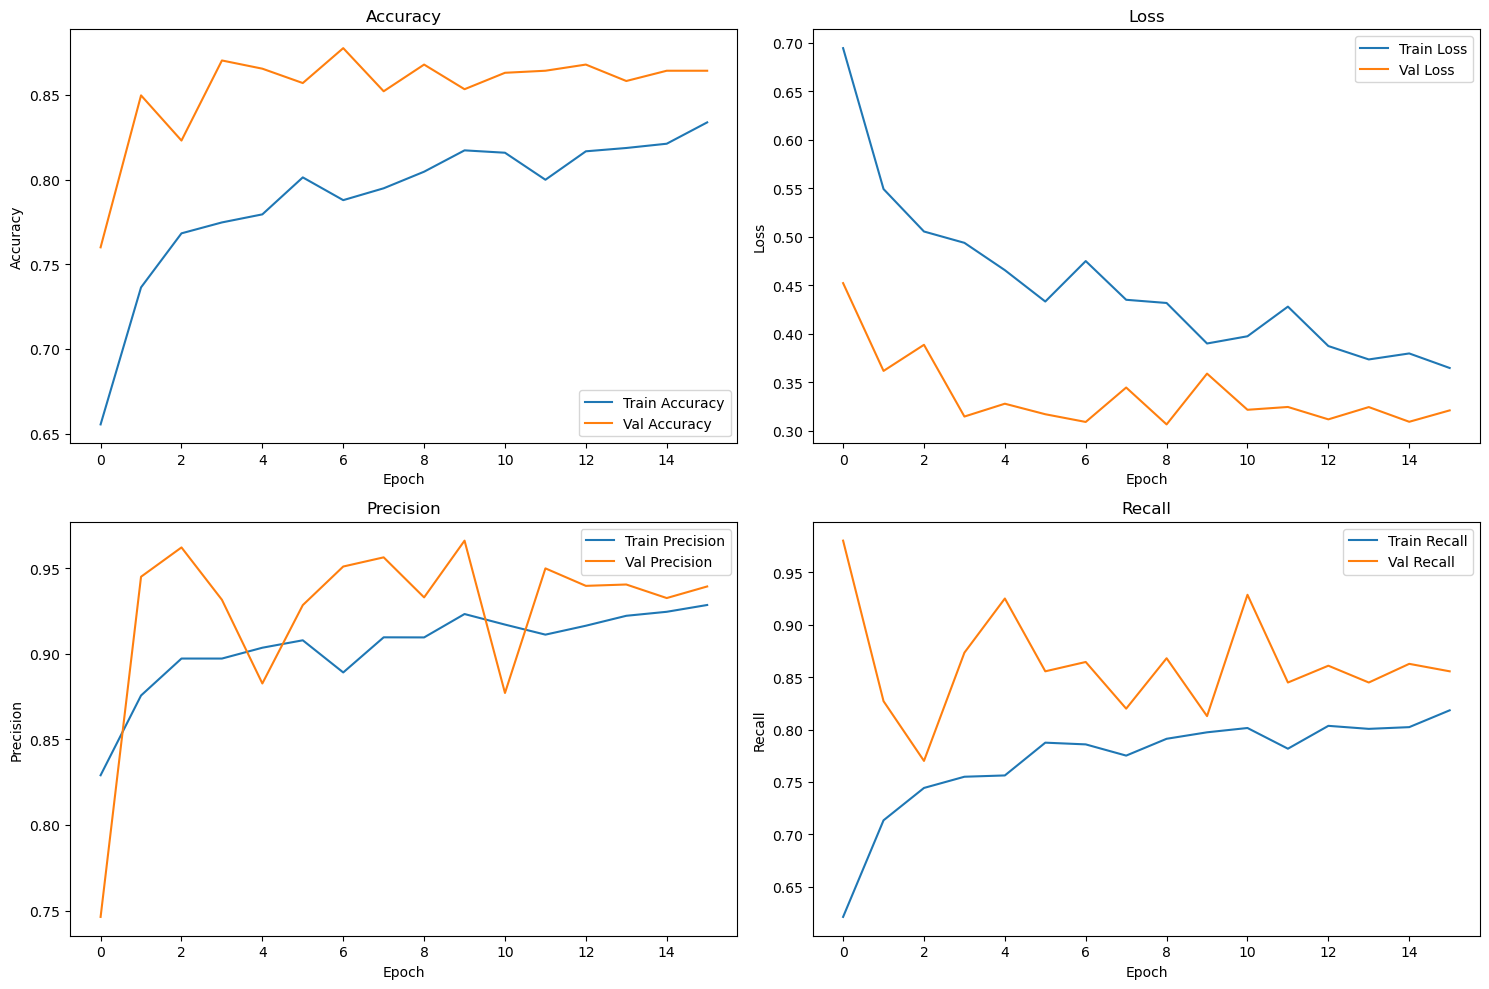

In [ ]:
plot_hybrid_history(history_vgg)


* Segundo modelo

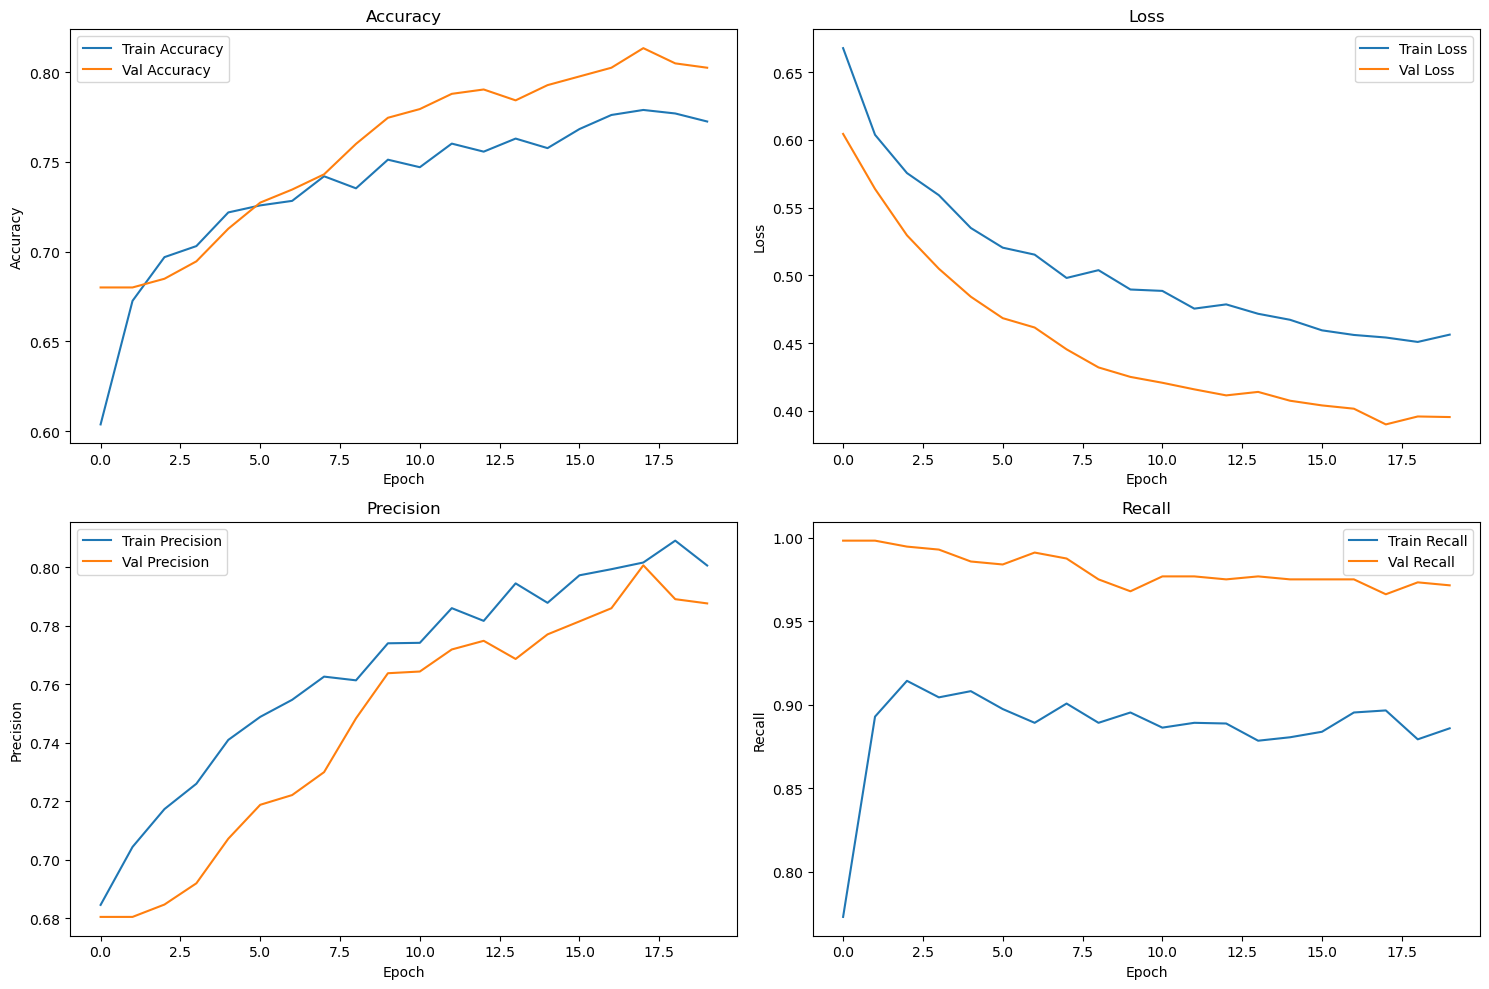

In [ ]:
plot_hybrid_history(history_effnet)

*Segundo modelo + fine tunning

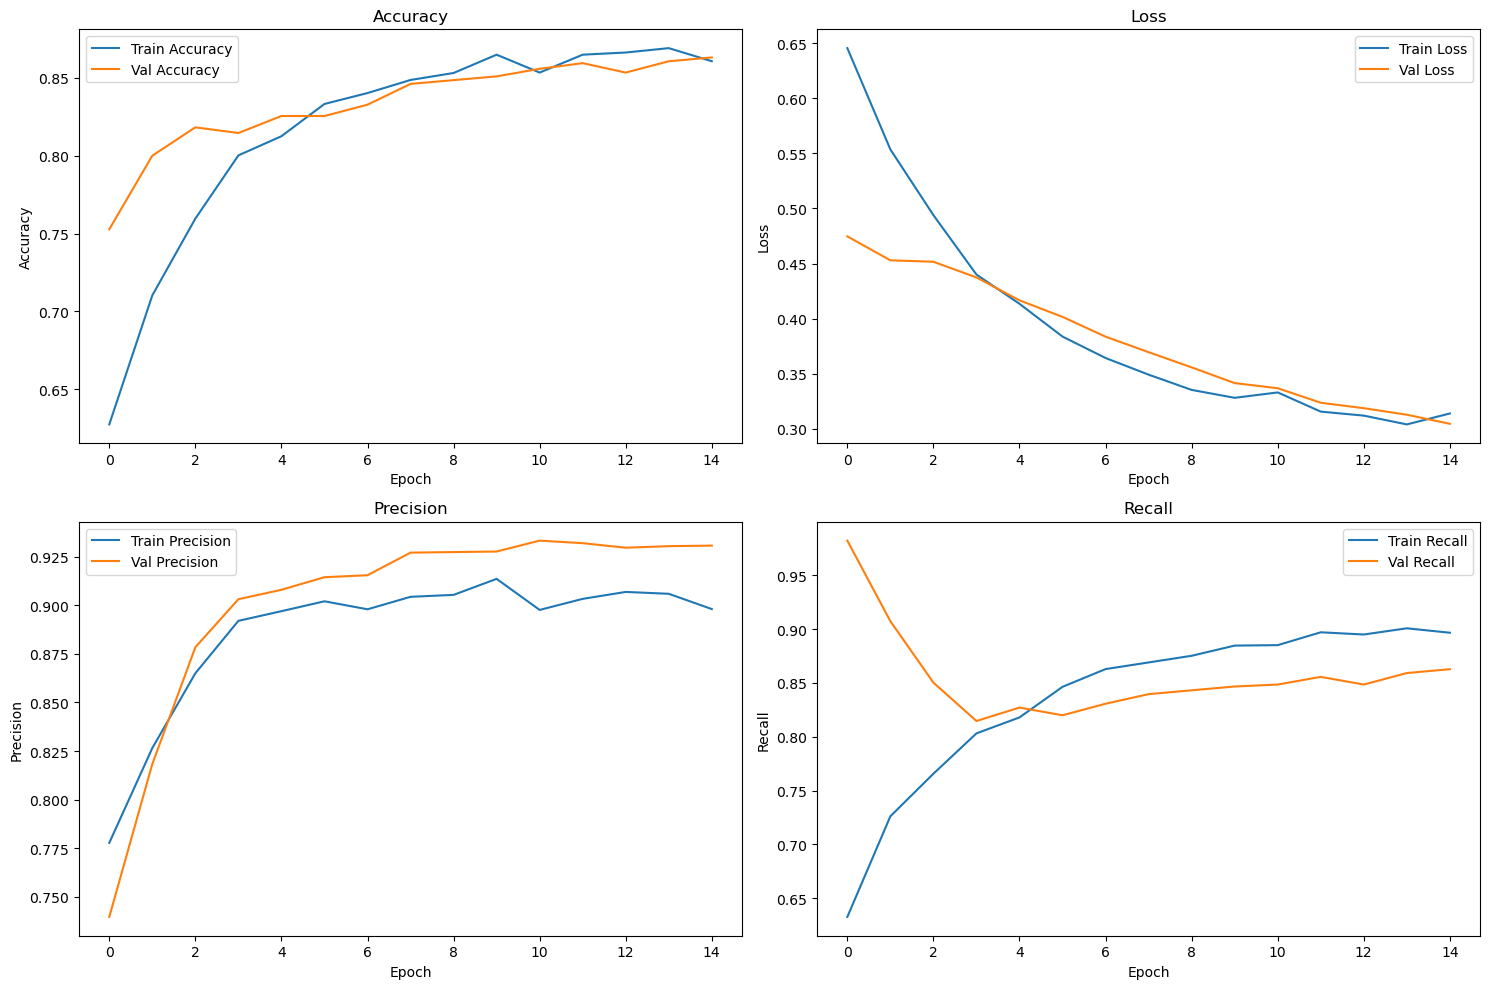

In [ ]:
plot_hybrid_history(history_fine)

* Tercer Modelo

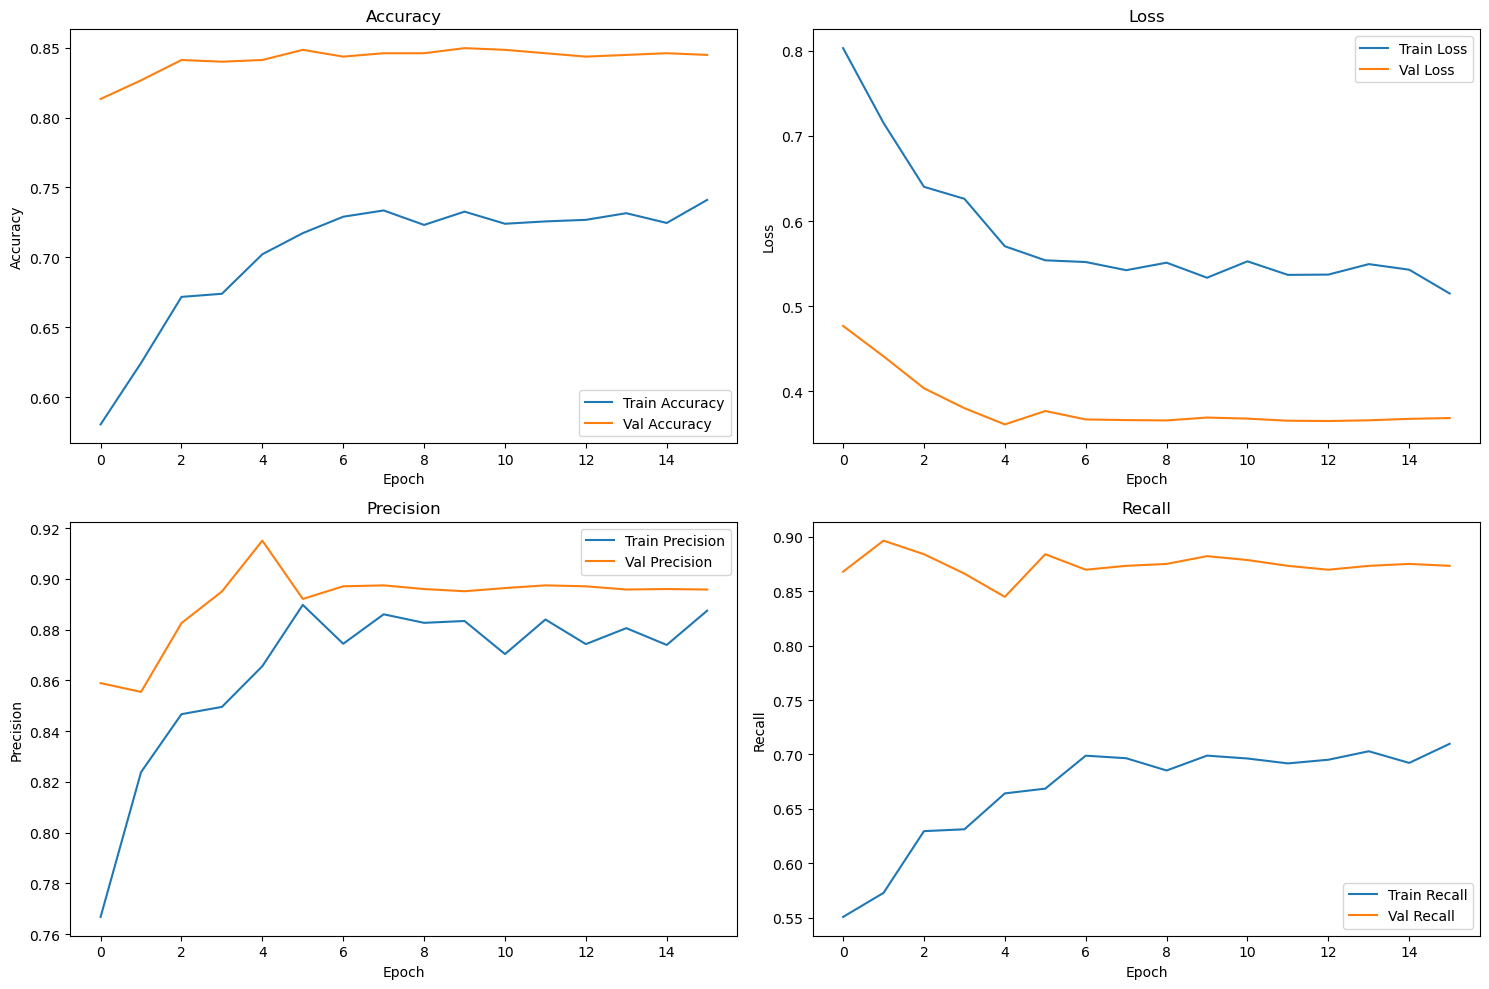

In [ ]:
plot_hybrid_history(history_hybrid)

# ***7.Evaluación***

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

def evaluar_modelo(modelo, generator, nombre_modelo="Modelo"):
    """
    Evalúa un modelo sobre un generador, mostrando:
    - Reporte de clasificación
    - Matriz de confusión
    - Curva ROC
    """
    print(f"\n== Evaluando {nombre_modelo} ==")

    # Predicciones
    pred_probs = modelo.predict(generator)
    preds = (pred_probs > 0.5).astype(int)

    # Etiquetas verdaderas
    true_labels = generator.classes

    # Reporte de clasificación
    print("\nClassification Report:")
    print(classification_report(true_labels, preds, target_names=['Tempranas', 'Tardías']))

    # Matriz de confusión
    cm = confusion_matrix(true_labels, preds)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Tempranas', 'Tardías'],
                yticklabels=['Tempranas', 'Tardías'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title(f'Confusion Matrix - {nombre_modelo}')
    plt.show()

    # Curva ROC
    fpr, tpr, _ = roc_curve(true_labels, pred_probs)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {nombre_modelo}')
    plt.legend(loc="lower right")
    plt.show()


* Primer modelo


== Evaluando VGG16 ==
35/35 ━━━━━━━━━━━━━━━━━━━━ 10s 272ms/step

Classification Report:
              precision    recall  f1-score   support

   Tempranas       0.74      0.83      0.78       353
     Tardías       0.92      0.86      0.89       747

    accuracy                           0.85      1100
   macro avg       0.83      0.85      0.84      1100
weighted avg       0.86      0.85      0.86      1100



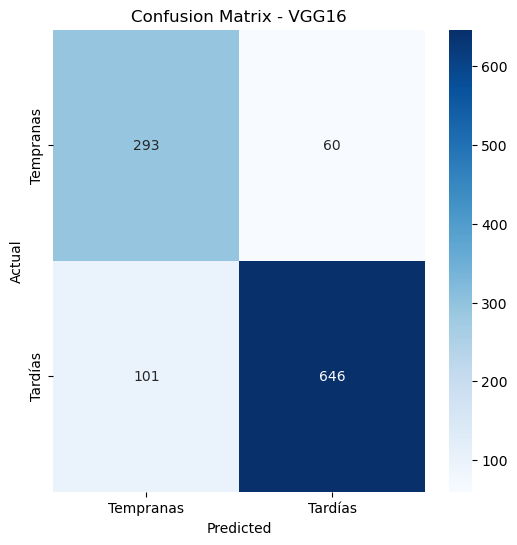

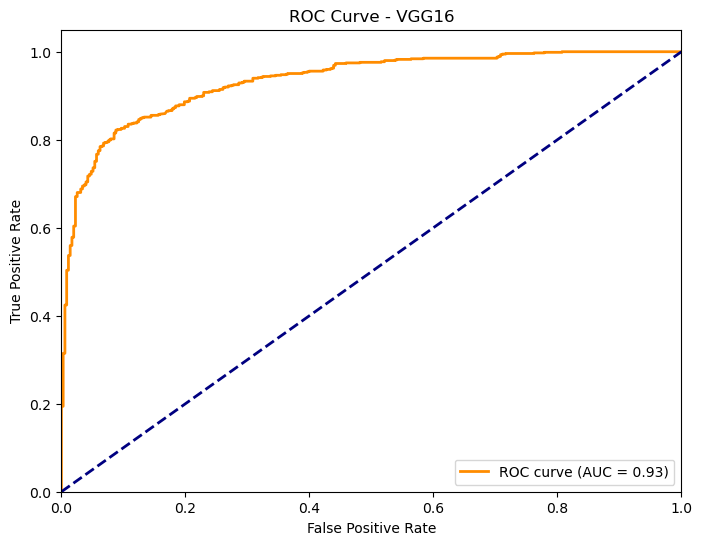

In [ ]:
evaluar_modelo(model_vgg, test_generator_vgg, nombre_modelo="VGG16")

*Segundo Modelo


== Evaluando EfficientNetB0 ==


/home/mauricio/miniconda3/envs/tf-gpu/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/35 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step

2025-06-03 02:03:50.861951: E external/local_xla/xla/service/slow_operation_alarm.cc:65] Trying algorithm eng3{k11=2} for conv (f32[12,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,480,8,8]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config={"cudnn_conv_backend_config":{"activation_mode":"kNone","conv_result_scale":1,"leakyrelu_alpha":0,"side_input_scale":0},"force_earliest_schedule":false,"operation_queue_id":"0","wait_on_operation_queues":[]} is taking a while...
2025-06-03 02:03:51.469706: E external/local_xla/xla/service/slow_operation_alarm.cc:133] The operation took 1.602508381s
Trying algorithm eng3{k11=2} for conv (f32[12,480,8,8]{3,2,1,0}, u8[0]{0}) custom-call(f32[12,480,8,8]{3,2,1,0}, f32[480,1,5,5]{3,2,1,0}), window={size=5x5 pad=2_2x2_2}, dim_labels=bf01_oi01->bf01, feature_group_count=480, custom_call_target="__cudnn$convForward", backend_config=

35/35 ━━━━━━━━━━━━━━━━━━━━ 30s 717ms/step

Classification Report:
              precision    recall  f1-score   support

   Tempranas       0.75      0.83      0.79       353
     Tardías       0.92      0.87      0.89       747

    accuracy                           0.86      1100
   macro avg       0.83      0.85      0.84      1100
weighted avg       0.86      0.86      0.86      1100



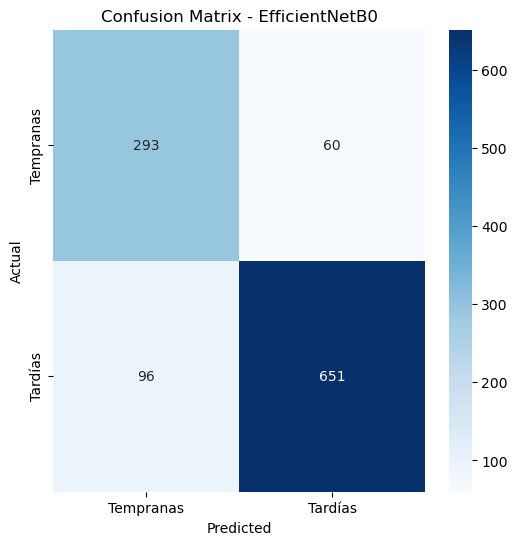

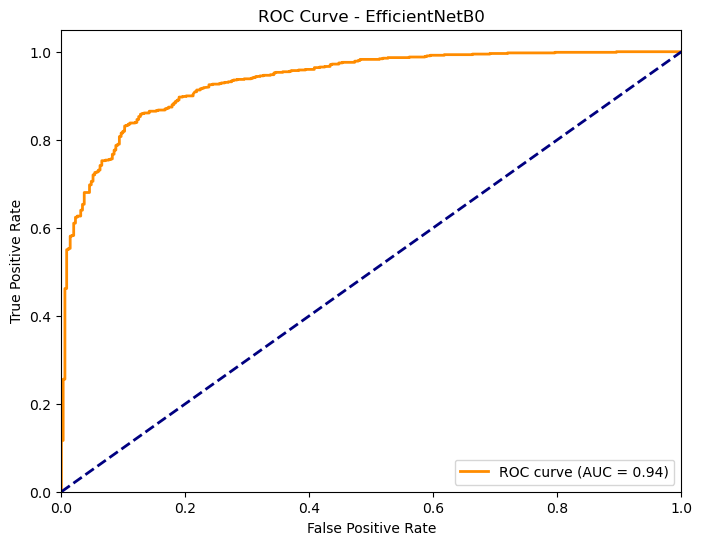

In [ ]:
evaluar_modelo(model_effnet, test_generator_effnet, nombre_modelo="EfficientNetB0")

* Tercer modelo

In [ ]:
evaluar_modelo(model_hybrid, val_dataset, nombre_modelo="Modelo Híbrido")


== Evaluando Modelo Híbrido ==
    604/Unknown 39s 65ms/step

KeyboardInterrupt: 